In [3]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/deconv/")

results_dir.mkdir(parents=True, exist_ok=True)

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Load input RNA allelic counts. We should know have good depth for both biological replicates. 

In [4]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = { "rep1" : basedir + "input-rep1_allelic.out", # this is bio rep 1 (two sequencing runs combined)
               "rep2" : basedir + "input-rep2_allelic.out" }

input_counts = { k:pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for k,f in input_files.items() }
input_counts["rep1"].head()

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,26,0,26
1,chr1,16141,rs529651976,C,T,52,2,54
2,chr1,16280,.,T,C,29,0,29
3,chr1,128747,rs565117739,A,C,10,1,11
4,chr1,137978,rs529853750,G,A,520,1,521


There is some weirdness where one rsID maps to two positions. deconvolve.merge will just filter these out. 

Observed genotype data (after running StrandScript)

In [5]:
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


# Deconvolution

sum(w)=1.001391 ideally would be 1


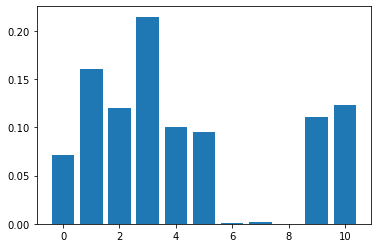

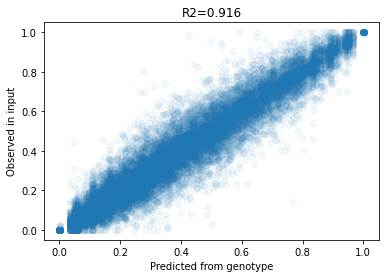

sum(w)=0.998289 ideally would be 1


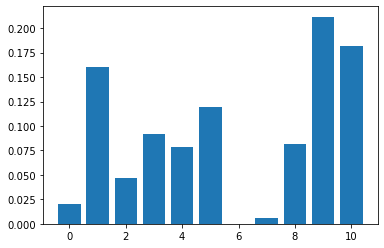

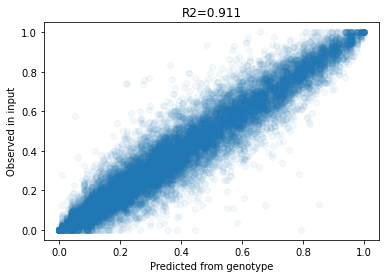

In [6]:
w = { k: deconvolve.deconvolve(geno, inp) for k,inp in input_counts.items() }

In [7]:
for rep_index in w:
    props = pd.DataFrame({ "proportion" : w[rep_index] })
    props["line"] = geno.columns[5:16]
    props = props.iloc[:,[1,0]]
    props.to_csv(results_dir / ("deconv_%s.tsv" % rep), index = False, sep = "\t")

NameError: name 'rep' is not defined

# Load imputed genotypes

In [ ]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [ ]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

# Load IP count data and join with input and genotype

In [ ]:
IP_files_all = {
    "HNRNPK" : {
        "rep1" : basedir + "hnrnpk-rep1_allelic.out", 
        "rep2" : basedir + "hnrnpk-rep2_allelic.out"
    },
    "RBFOX2" : { "rep2" : basedir + "rbfox2-rep2_allelic.out" }, 
    "HNRNPA1" : { "rep1" : basedir + "hnrnpa1-rep1_allelic.out" }
}

for rbp,IP_files in IP_files_all.items(): 
    print(rbp,"---------------------------------")
    
    results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/" + rbp)
    
    IP_counts = { k:pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for k,f in IP_files.items() }
    
    print("IP counts:",{ k:v.totalCount.sum()/1e6 for k,v in IP_counts.items() })
    print("Input counts",{ k:v.totalCount.sum()/1e6 for k,v in input_counts.items() })
    merged = {} 
    dat_sub = {}
    for rep in IP_counts:
        merged[rep],dat_sub[rep] = deconvolve.merge_geno_and_counts(
            sanger, 
            input_counts[rep], 
            IP_counts[rep], 
            w[rep], 
            plot = True)

        merged[rep].to_csv(results_dir / ("merged_%s.tsv.gz" % rep), index = False, sep = "\t")
        dat_sub[rep].to_csv(results_dir / ("filtered_%s.tsv.gz" % rep), index = False, sep = "\t")

In [ ]:
temp = merged["rep1"][(merged["rep1"].pred > 1./18) & (merged["rep1"].pred < 1 - 1./18)]
plt.hist(temp.IP_ratio, 30)

In [ ]:
print("IP counts:",{ k:v.totalCount.sum()/1e6 for k,v in IP_counts.items() })

In [ ]:
w_IP = {} 

for rbp,IP_files in IP_files_all.items(): 
    print(rbp,"---------------------------------")
    
    results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/" + rbp)
    
    IP_counts = { k:pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for k,f in IP_files.items() }
    
    w_IP[rbp] = { k: deconvolve.deconvolve(geno, counts) for k,counts in IP_counts.items() }

In [ ]:
pd.DataFrame(w_IP)

In [ ]:
w_IP_t = {}
for rbp in w_IP: # print(rbp)
    for rep in w_IP[rbp]:
        if not rep in w_IP_t: 
            w_IP_t[rep] = {}
        w_IP_t[rep][rbp] = w_IP[rbp][rep]

labels = [ g.split("-")[0] for g in geno.columns[5:16] ]

df={}
for rep in w: 
    w_IP_t[rep]["input"] = w[rep]
    df[rep] = pd.DataFrame(w_IP_t[rep])
    df[rep]["labels"] = labels
    df[rep]["rep"] = rep

In [ ]:
big = pd.concat([ pd.melt(df[rep], ["labels","rep"], var_name = "assay") for rep in df ])
big.head()

Filter out unused cell lines

In [ ]:
import plotnine as p9

big = big[~np.logical_or(big.labels == "CW30190", big.labels == "CW30108")]
myplot = ( 
    p9.ggplot(big, p9.aes(x = "labels", y = "value", fill = "assay")) + 
    p9.geom_col(position = "dodge") + 
    p9.coord_flip() + 
    p9.ylab("Estimated proportion of sample") + 
    p9.xlab("iPSC cell line") + 
    p9.facet_wrap("rep")
)
myplot.save("props.pdf")
myplot

In [ ]:
melted = pd.melt(df, "labels")
melted.head()


In [ ]:
import plotnine as p9
( 
    p9.ggplot(melted, p9.aes(x = "labels", y = "value", fill = "variable")) + 
    p9.geom_col(position = "dodge") + 
    p9.coord_flip() + 
    p9.ylab("Estimated proportion of sample") + 
    p9.xlab("iPSC cell line")
)